# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Applications/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


#### Basic Data Analysis

In [3]:
print type(train_data)
print type(train_labels)

<type 'list'>
<type 'numpy.ndarray'>


In [4]:
train_data[:5]

[u"Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych",
 u'\n\nSeems to be, barring evidence to the contrary, that Koresh was simply\nanother deranged fanatic who thought it neccessary to take a whole bunch of\nfolks with him, children and all, to satisfy his delusional mania. Jim\nJones, circa 1993.\n\n\nNope - fruitcakes like Koresh have been demonstrating such evil corruption\nfor centuries.',
 u"\n >In article <1993Apr19.

In [5]:
train_labels[0:5]

array([1, 3, 2, 0, 2])

#### Project

(1) For each of the first 5 training examples, print the text of the message along with the label.

In [6]:
def P1(num_examples=5):
    # print the first 5 training examples with the label number and text
    for i in range(num_examples):
        print "="*100
        print "Example:", i+1
        print "-"*100
        print "Text:"
        print train_data[i]
        print "-"*100
        print "Label: ", train_labels[i], newsgroups_train.target_names[train_labels[i]]
        print "="*100
        print ""
    
P1()

Example: 1
----------------------------------------------------------------------------------------------------
Text:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
----------------------------------------------------------------------------------------------------
Label:  1 comp.graphics

Example: 2
----------------------------------------------------------------------------------------------------
Text:


Seems to be, barring eviden

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

#### Part (a)

In [7]:
# Fit and transform the train_data using the CountVectorizer
vec = CountVectorizer()
data = vec.fit_transform(train_data)
# Confirm the output of the fit_transform function is a sparse matrix
print "CountVectorizer output type:", type(data)
print "CountVectorizer output shape:", data.shape

# Two ways of getting the vocabulary from the fit model
train_vocab = sorted(vec.vocabulary_.keys())
train_vocab1 = vec.get_feature_names()

# Confirm that the two methods produce the same results
print "Confirming two vocabularies are the same:", train_vocab == train_vocab1

# There ways to get the size of the vocabulary
vocab = data.shape[1]
vocab1 = len(train_vocab)
vocab2 = len(train_vocab1)

# Confirm that the there methods produce the same results
print "Confirming the three vocabulary sizes are the same:", vocab == vocab1 == vocab2
print ""

# average number of non-zero features per example
total_nnz = data.nnz
ave_nnz = float(total_nnz) / float(data.shape[0])

# fraction of non-zero matrix entries
fraction_nnz = 100 * float(total_nnz) / float(data.shape[0] * data.shape[1])

print "Answers to the questions"
print "The size of the vocabulary is:", vocab
print "The average number of non-zero features per example is:", round(ave_nnz,1)
print "The fraction of non-zero matrix entries is:", str(round(fraction_nnz,1)) + "%"



CountVectorizer output type: <class 'scipy.sparse.csr.csr_matrix'>
CountVectorizer output shape: (2034, 26879)
Confirming two vocabularies are the same: True
Confirming the three vocabulary sizes are the same: True

Answers to the questions
The size of the vocabulary is: 26879
The average number of non-zero features per example is: 96.7
The fraction of non-zero matrix entries is: 0.4%


Observation: The matrix is very sparse, which is usually the case in this style of document analysis.

#### Part (b)

In [8]:
# get first and last feature in alphabetic order
print "Answers to the questions"
print "The first feature string in the vocabulary is:", vec.get_feature_names()[0]
print "The last feature string in the vocabulary is:", vec.get_feature_names()[-1]

Answers to the questions
The first feature string in the vocabulary is: 00
The last feature string in the vocabulary is: zyxel


#### Part (c)

In [9]:
my_vocab = ["atheism", "graphics", "space", "religion"]
vec = CountVectorizer(vocabulary=my_vocab)
data = vec.fit_transform(train_data)

# average number of non-zero features per example
total_nnz = data.nnz
ave_nnz = float(total_nnz) / float(data.shape[0])

# fraction of non-zero matrix entries
fraction_nnz = 100 * float(total_nnz) / float(data.shape[0] * data.shape[1])

print "Answers to the questions"
print "CountVectorizer output shape:", data.shape
print "The size of the vocabulary is:", data.shape[1]
print "The average number of non-zero features per example is:", round(ave_nnz,1)
print "The fraction of non-zero matrix entries is:", str(round(fraction_nnz,1)) + "%"




Answers to the questions
CountVectorizer output shape: (2034, 4)
The size of the vocabulary is: 4
The average number of non-zero features per example is: 0.3
The fraction of non-zero matrix entries is: 6.7%


Observation: The number of features per example drops because it can now only be a maximum of 4 if the 4 words in the vocabulary were all to appear in each example. The fraction of non-zero matrix entries rises because the words must appear in a reasonable number of the examples compared to the broader average word frequency across all features for the full vocabulary. This is not surprising given the words in this vocabulary are the topic areas of all the examples. The more common the word the higher the number of non-zero entries. For example if we had a vocab of just ['the'] the non-zero entries would likely be much higher.

#### Part (d)

In [10]:
# Fit and transform to include bi-grams
vec = CountVectorizer(analyzer='word',ngram_range=(1,2))
data = vec.fit_transform(train_data)
vocab_bi = data.shape[1]

# Fit for transform to include tri-grams
vec = CountVectorizer(analyzer='word',ngram_range=(1,3))
data = vec.fit_transform(train_data)
vocab_tri = data.shape[1]

print "Answers to the questions"
print "By including bi-grams the vocabulary increases from", vocab, "to", vocab_bi
print "By including tri-grams the vocabulary further increases from", vocab_bi, "to", vocab_tri


Answers to the questions
By including bi-grams the vocabulary increases from 26879 to 221770
By including tri-grams the vocabulary further increases from 221770 to 537462


Observation: By adding bi-grams and tri-grams it quickly increases the feature set size, but may add value in picking up additional context.

#### Part (e)

In [11]:
# Fit allowing for features that appear in a minimum of 10 examples
vec = CountVectorizer(min_df=10)
data = vec.fit_transform(train_data)
vocab_mindf10 = data.shape[1]
print "By only selecting features that appear in at least 10 examples the vocabulary significantly declines from", vocab, "to", str(vocab_mindf10) + "."

By only selecting features that appear in at least 10 examples the vocabulary significantly declines from 26879 to 3064.


#### Part (f)

In [12]:
vec = CountVectorizer()
data = vec.fit_transform(dev_data)
dev_vocab = vec.get_feature_names()
missing = sum([1 for feature in dev_vocab if feature not in train_vocab])
fraction_missing = round(100 * float(missing) / len(dev_vocab),1)
print "The fraction of features in the dev data set that are not in the training data set is:", str(fraction_missing)+"%"



The fraction of features in the dev data set that are not in the training data set is: 24.8%


Observation: This highlights the difficulty of this approach in that when a word is not encountered in the training data set it makes predictions in held back data sets more difficult. Part (e) further highlights this difficulty showing for this set of document examples around 90% of features appear in 10 or less of the examples. As is usually the case the more examples you have the better it will likely work.

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

Fitting 10 folds for each of 199 candidates, totalling 1990 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1990 out of 1990 | elapsed:   42.2s finished


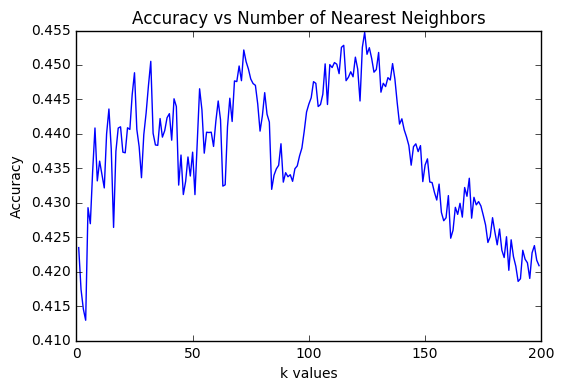

Best score: 0.455
Best parameters:
clf1__n_neighbors 124
K Nearest Neighbours F-score: 0.496


In [13]:
# Fit and transform the training data using the CountVectorizer
vec = CountVectorizer()
t_data = vec.fit_transform(train_data)
# Set up k nearest neighbors pipeline
pipeline = Pipeline([('clf1', KNeighborsClassifier())])
# Set k to be in the range 1 to 200
parameters = {'clf1__n_neighbors': range(1,200)}
# Set GridSearchCV with cross validation of 10 and F1 scoring
grid_search = GridSearchCV(pipeline, parameters,n_jobs=-1,cv=10,verbose=1,scoring='f1_weighted')
# fit the GridSearch using the training features from the CountVectorizer
grid_search.fit(t_data,train_labels)
# Collect the mean score across the 10 cross validations 
scores = []
k_values = []
for item in grid_search.grid_scores_:
    scores.append(item.mean_validation_score)
    k_values.append(item.parameters['clf1__n_neighbors'])
# plot the scores against the k values
plt.plot(k_values,scores)
plt.title("Accuracy vs Number of Nearest Neighbors")
plt.ylabel("Accuracy")
plt.xlabel("k values")
plt.show()
# report the best parameters
print "Best score:", round(grid_search.best_score_,3)
print "Best parameters:"
best_parameters = grid_search.best_estimator_.get_params()
for parameter_name in sorted(parameters.keys()):
    print parameter_name, best_parameters[parameter_name]
# report the F1 score for the best parameters
# predict() is performed using the best parameters from the grid_search
preds = grid_search.predict(t_data)
print "K Nearest Neighbours F-score:", round(metrics.f1_score(train_labels,preds,average='weighted'),3)   


ANSWER: Part (a) k Nearest neighbours tends not to work well in this instance because of the sparsity of the data and data is not overly continuous, i.e. there are a lot of zeros, only a few non zero terms that typically take on a small range of integer values. These features will likely cause distance metrics to be quite similar (lots of zeros) and volatile (due to the influence that small discrete changes in feature frequency can have). Accordingly, the results are very corpus dependent which makes select of k difficult as highlighted by the volatility of the results in the chart above.

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


mean: 0.82799, std: 0.02502, params: {'clf2__alpha': 1e-08}
mean: 0.83821, std: 0.02716, params: {'clf2__alpha': 0.0001}
mean: 0.83745, std: 0.02816, params: {'clf2__alpha': 0.001}
mean: 0.83905, std: 0.02671, params: {'clf2__alpha': 0.01}
mean: 0.83154, std: 0.02023, params: {'clf2__alpha': 0.1}
mean: 0.80745, std: 0.02203, params: {'clf2__alpha': 1}
mean: 0.79453, std: 0.02804, params: {'clf2__alpha': 2}
mean: 0.77380, std: 0.03414, params: {'clf2__alpha': 4}
mean: 0.72106, std: 0.04525, params: {'clf2__alpha': 8}
mean: 0.66760, std: 0.04390, params: {'clf2__alpha': 16}


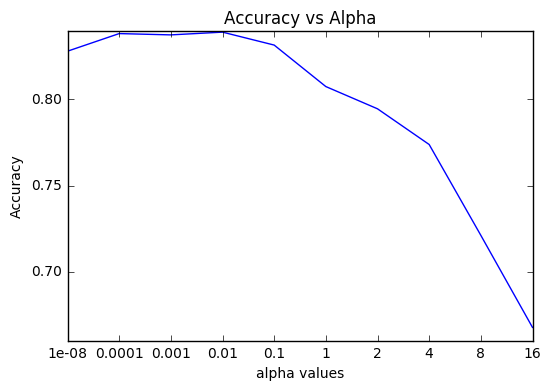

Best score: 0.839
Best parameters:
clf2__alpha 0.01
MultinomialNB F-score: 0.961


In [14]:
# Fit and transform the training data using the CountVectorizer
vec = CountVectorizer()
t_data = vec.fit_transform(train_data)
# Set up MultinomialNB classifier pipeline
pipeline = Pipeline([('clf2', MultinomialNB())])
parameters = {'clf2__alpha': (0.00000001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 4, 8, 16)}
# Set GridSearchCV with cross validation of 10 and F1 scoring
grid_search = GridSearchCV(pipeline, parameters,n_jobs=-1,cv=10,verbose=1,scoring='f1_weighted')
# Fit the GridSearch using the training features from the CountVectorizer
grid_search.fit(t_data,train_labels)
# Collect the mean score across the 10 cross validations 
scores = []
alpha_values = []
for item in grid_search.grid_scores_:
    print item
    item.mean_validation_score
    scores.append(item.mean_validation_score)
    alpha_values.append(item.parameters['clf2__alpha'])
# plot the scores against the alpha values
N = len(alpha_values)
x2 = np.arange(N)
plt.plot(x2,scores)
plt.xticks(x2, alpha_values)
plt.title("Accuracy vs Alpha")
plt.ylabel("Accuracy")
plt.xlabel("alpha values")
plt.show()
# report the best parameters
print "Best score:", round(grid_search.best_score_,3)
print "Best parameters:"
best_parameters = grid_search.best_estimator_.get_params()
for parameter_name in sorted(parameters.keys()):
    print parameter_name, best_parameters[parameter_name]
# report the F1 score for the best parameters    
# note predict() is performed using the best parameters
preds = grid_search.predict(t_data)
print "MultinomialNB F-score:", round(metrics.f1_score(train_labels,preds,average='weighted'),3)   


Fitting 10 folds for each of 7 candidates, totalling 70 fits


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 

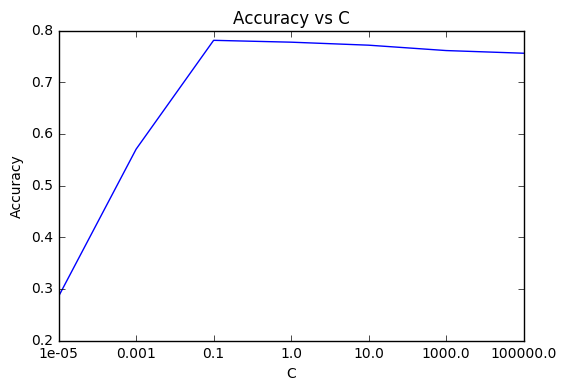

Best score: 0.781
Best parameters:
clf3__C 0.1
Logistic Regression F-score: 0.955


In [15]:
# Fit and transform the training data using the CountVectorizer
vec = CountVectorizer()
t_data = vec.fit_transform(train_data)
# Set up Logistic Regression pipeline
pipeline = Pipeline([('clf3', LogisticRegression(multi_class='ovr',solver='newton-cg'))])
# Set parameters for the GridSearchCV
parameters = {'clf3__C': (1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e3, 1e5)}
# Set GridSearchCV with cross validation of 10 and F1 scoring
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10, verbose=1,scoring='f1_weighted')
# Fit the GridSearch using the training features from the CountVectorizer
grid_search.fit(t_data,train_labels)
# Collect the mean score across the 10 cross validations 
scores = []
Cs = []
for item in grid_search.grid_scores_:
    scores.append(item.mean_validation_score)
    Cs.append(item.parameters['clf3__C'])
# plot the scores against the C values
N = len(Cs)
x2 = np.arange(N)
plt.plot(x2,scores)
plt.xticks(x2,Cs)
plt.title("Accuracy vs C")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.show()
# report the best parameters
print "Best score:", round(grid_search.best_score_,3)
print "Best parameters:"
best_parameters = grid_search.best_estimator_.get_params()
for parameter_name in sorted(parameters.keys()):
    print parameter_name, best_parameters[parameter_name]
# report the F1 score for the best parameters   
# note predict() is performed using the best parameters
preds = grid_search.predict(t_data)
print "Logistic Regression F-score:", round(metrics.f1_score(train_labels,preds,average='weighted'),3)   


In [16]:
# Fit and transform the train_data using the CountVectorizer
vec = CountVectorizer()
t_data = vec.fit_transform(train_data)

# Set C values for the Logistic Regression
C_values = [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e3, 1e5]
scores = []

for i in range(len(C_values)):
    sq_wgt_sums = [0] * 4
    clf = LogisticRegression(C=C_values[i], multi_class='ovr', solver='newton-cg')
    clf.fit(t_data, train_labels)
    coefs = pd.DataFrame(clf.coef_)
    for k in range(clf.coef_.shape[1]):
        for j in range(clf.coef_.shape[0]):
            sq_wgt_sums[j] += clf.coef_[j][k] ** 2
    print " C values and sume of squared weights by class:"
    print "C value:", C_values[i], round(sq_wgt_sums[0],3), round(sq_wgt_sums[1],3), round(sq_wgt_sums[2],3), round(sq_wgt_sums[3],3)


 C values and sume of squared weights by class:
C value: 1e-05 0.0 0.0 0.0 0.0
 C values and sume of squared weights by class:
C value: 0.001 0.12 0.196 0.164 0.115
 C values and sume of squared weights by class:
C value: 0.1 27.166 24.76 27.53 22.9
 C values and sume of squared weights by class:
C value: 1.0 167.239 130.953 158.102 145.755
 C values and sume of squared weights by class:
C value: 10.0 586.188 448.639 539.312 530.779
 C values and sume of squared weights by class:
C value: 1000.0 2722.318 2124.759 2504.368 2588.226
 C values and sume of squared weights by class:
C value: 100000.0 7001.996 5471.431 6363.307 6722.07


ANSWER:

Part (b) It is possibly that the direct application of feature probabilities works better in integer feature space for Multinomial Naive Bayes than for the logistic regression, also the logistic regression has to do a one versus rest approach with the multi-class problem, which possibly reduces its relative predictive ability. 

Part (c) As flagged in Q6 "the idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights.  The result is that L2 regularization makes all the weights relatively small." Accordingly as we can see as the regularisation parameter comes down the aggregate of the sumof sqaured weights of each class comes down as expected.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [17]:
def get_largest_weights(vec, clf, num=5, print_table=True):
    # collect indices of the top 5 weighted features in the classifier
    inds = []
    coefs = pd.DataFrame(clf.coef_)
    for i in range(4):
        for item in coefs.transpose().nlargest(num, i).index.values:
            inds.append(item)
    # collect feature, label and feature weights 
    features = []
    for i in inds:
        mfeature = []
        mfeature.append(int(inds.index(i)/num))
        mfeature.append(vec.get_feature_names()[i])
        for j in range(4):
            mfeature.append(round(clf.coef_.T[i][j],3))
        features.append(mfeature)
    final_table = pd.DataFrame(features, columns=['Label','Feature','0','1','2','3'])
    if print_table: 
        print final_table    
    return final_table
    
def P4(C=1,ng=1):
    # Fit and transform a CountVectorizer
    vec = CountVectorizer(ngram_range=(ng,ng))
    t_data = vec.fit_transform(train_data)
    # Define and fit a Logistic Regression
    clf = LogisticRegression(C=C, solver='newton-cg')
    clf.fit(t_data,train_labels)
    # Get the largest weights
    final_table = get_largest_weights(vec, clf)
        
print "Single word feature analysis" 
P4(0.1)
print ""

print "Bi-gram feature analysis" 
P4(ng=2)
print ""


Single word feature analysis
    Label     Feature      0      1      2      3
0       0    religion  0.500 -0.294 -0.390  0.008
1       0     atheism  0.494 -0.215 -0.196 -0.268
2       0       bobby  0.483 -0.119 -0.166 -0.224
3       0    atheists  0.468 -0.079 -0.158 -0.292
4       0       islam  0.428 -0.088 -0.167 -0.163
5       1    graphics -0.400  1.017 -0.644 -0.359
6       1        file -0.167  0.651 -0.415 -0.277
7       1       image -0.255  0.651 -0.363 -0.206
8       1          3d -0.176  0.554 -0.307 -0.175
9       1    computer -0.036  0.553 -0.332 -0.223
10      2       space -0.642 -0.712  1.267 -0.576
11      2       orbit -0.213 -0.335  0.603 -0.240
12      2        nasa -0.271 -0.267  0.544 -0.246
13      2      launch -0.206 -0.243  0.483 -0.165
14      2        moon -0.200 -0.291  0.406 -0.052
15      3   christian -0.260 -0.186 -0.191  0.548
16      3  christians -0.324 -0.156 -0.196  0.511
17      3       blood -0.210 -0.064 -0.097  0.433
18      3       order

ANSWER: The bi-grams feature analysis is a little surprising overall because many of the highly weighted bi-gram features are not obviously related to the topic of the class. For example, it is hard to relate 'out there' to 'comp.graphics' or 'compuserve com' to 'talk.religion.misc', on the face of it you may have expected the opposite relationship. In a similar vein the single word features that weight highly tend to be topic-related nouns, while the bi-grams are typically not topic-related nouns. The bi-gram analysis also appears to pick up some spurious relationships like 'cheers kent' for the 'alt.atheism' class. These results tend to suggests there may not be much value in adding bi-grams to the feature set, which is what I found.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [18]:
# A variety of pre-processing functions

punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
digits = "0123456789"

def change_to_lowercase(my_str):
    """Convert my_str to lower case"""
    my_str = my_str.lower()
    return my_str

def short_form_replace(my_str):
    """Convert apostrophes in known short-forms in my_str to long-forms"""
    my_str = re.sub(r'let\'s', "let us", my_str)
    my_str = re.sub(r'won\'t', "will not", my_str)
    my_str = re.sub(r'can\'t', "cannot", my_str)
    my_str = re.sub(r'shan\'t', "shall not", my_str)
    my_str = re.sub(r'n\'t', " not", my_str)
    my_str = re.sub(r'\'ve', " have", my_str)
    my_str = re.sub(r'\'re', " are", my_str)
    my_str = re.sub(r'\'m', " am", my_str)
    my_str = re.sub(r'\'ll', " will", my_str)
    my_str = re.sub(r'\'d', " would", my_str)     # note could also be did or had as well
    my_str = re.sub(r'it\'s', "it is", my_str)
    my_str = re.sub(r'he\'s', "he is", my_str)
    my_str = re.sub(r'she\'s', "she is", my_str)
    my_str = re.sub(r'that\'s', "that is", my_str)
    my_str = re.sub(r'what\'s', "what is", my_str)
    my_str = re.sub(r'here\'s', "here is", my_str)
    my_str = re.sub(r'there\'s', "there is", my_str)
    my_str = re.sub(r'who\'s', "who is", my_str)
    return my_str

def apostrophe_s_replace(my_str):
    """Remove 's at the end of words in my_str. Best to run this after short_form_replace()"""
    my_str = re.sub(r"([A-z])\'s", r"\1", my_str)
    return my_str

def replace_apostrophes(my_str):
    """Tidy up my_str for all apostrophe-related issues."""
    my_str = short_form_replace(my_str)
    my_str = apostrophe_s_replace(my_str)
    return my_str

def hyphen_replace(my_str):
    """Replace hyphens in hyphenated words with a space"""
    my_str = re.sub(r"([A-z])(\-)([A-z])", r"\1 \3", my_str)
    my_str = re.sub(r"([A-z])(\-)(\s)([A-z])", r"\1 \4", my_str)
    return my_str

def forward_slash_replace(my_str):
    """Replace forward slashes in combined words with a space."""
    my_str = re.sub(r"([A-z])(/)([A-z])", r"\1 \3", my_str)
    my_str = my_str.replace(')/', ' ')
    my_str = my_str.replace('/(', ' ')
    return my_str

def remove_punctuation(my_str):
    """Remove all ASCII punctuation from my_str"""
    my_str = short_form_replace(my_str)  # replace short forms with long forms before removing punctuation
    my_str = ''.join(l for l in my_str if l not in punctuation)
    my_str = ' '.join(my_str.split())     # this changes all white spaces to single spaces
    return my_str

def remove_suffixes(my_str):
    """Basic attempt to do some stemming of 's' endings and other common endings."""
    my_str = re.sub(r"ssess ", r"ss ", my_str)
    my_str = re.sub(r"ies ", r"i ", my_str)
    my_str = re.sub(r"([^s])s ", r"\1 ", my_str)
    my_str = re.sub(r"ly ", r" ", my_str)
    my_str = re.sub(r"ing ", r" ", my_str)
    my_str = re.sub(r"ed ", r" ", my_str)
    my_str = re.sub(r"ion ", r" ", my_str)
    return my_str

def shorten_long_words(my_str, max_len=8):
    """Reduce words to a maximum length (default 8)."""
    my_str = my_str.split(" ")
    my_str = ' '.join([word[:max_len] for word in my_str])
    return my_str

def remove_short_words(my_str, min_len=3):
    """Remove words of length less than minimum length (default 3)."""
    my_str = my_str.split(" ")
    my_str = ' '.join([word for word in my_str if len(word)>=min_len])
    return my_str

def replace_digits(my_str):
    """Replace consecutive digits with a single #"""
    my_str = re.sub(r"([0-9])", r"#", my_str)
    my_str = re.sub(r'([#])\1+', r'\1', my_str)
    return my_str

def empty_preprocessor(my_str):
    return my_str
    
def better_preprocessor(my_str):
    """Pre-process my_str for various string issues to prepare for feature extraction"""
    my_str = change_to_lowercase(my_str)
    my_str = replace_apostrophes(my_str)
    my_str = hyphen_replace(my_str)
    my_str = forward_slash_replace(my_str)
    my_str = remove_punctuation(my_str)
    my_str = remove_suffixes(my_str)
    my_str = shorten_long_words(my_str)
    my_str = remove_short_words(my_str)
    my_str = replace_digits(my_str)
    return my_str
    
def example(n=0):
    test_string = train_data[n]
    print "Empty preprocessor:"
    print "-" * 50
    print empty_preprocessor(test_string)
    print ""
    print "Better preprocessor:"
    print "-" * 50
    print better_preprocessor(test_string)

# Show and example of the preprocessor at work
example(5)

Empty preprocessor:
--------------------------------------------------

There are definitely quite a few horrible deaths as the result of both
atheists AND theists.  I'm sure Bobby can list quite a few for the atheist
side but fails to recognize that the theists are equally proficient at
genocide.  Perhaps, since I'm a bit weak on history, somone here would like
to give a list of wars caused/led by theists?  I can think of a few (Hitler
claimed to be a Christian for example) but a more complete list would
probably be more effective in showing Bobby just how absurd his statement
is.


On a side note, I notice you always sign your posts "Peace".  Perhaps you
should take your own advice and leave the atheists in peace with their
beliefs?


Nanci

Better preprocessor:
--------------------------------------------------
there are definite quite few horrible death the result both atheist and theist sure bobby can list quite few for the atheist side but fail recogniz that the theist are equal 

In [19]:
def P5():
    
    vec = CountVectorizer(preprocessor=empty_preprocessor)
    t_data = vec.fit_transform(train_data)
    d_data = vec.transform(dev_data)
    vocab_empty_size = t_data.shape[1]
    # Logistic Regression
    clf = LogisticRegression(solver='newton-cg')
    clf.fit(t_data, train_labels)
    dev_preds = clf.predict(d_data)
    empty_f1 = round(metrics.f1_score(dev_labels,dev_preds,average='weighted'),3) 
    
    vec = CountVectorizer(preprocessor=better_preprocessor)
    t_data = vec.fit_transform(train_data)
    d_data = vec.transform(dev_data)
    vocab_better_size = t_data.shape[1]
    # Logistic Regression
    clf = LogisticRegression(solver='newton-cg')
    clf.fit(t_data, train_labels)
    dev_preds = clf.predict(d_data)
    better_f1 = round(metrics.f1_score(dev_labels,dev_preds,average='weighted'),3)   

    print "The size of the vocabulary falls from", vocab_empty_size, "to", vocab_better_size, "by using better_preprocessor()."
    print "The F1 score on the dev data increases from", empty_f1, "to", better_f1, "by using the better_preprocessor()." 
    
P5()

The size of the vocabulary falls from 33291 to 18477 by using better_preprocessor().
The F1 score on the dev data increases from 0.702 to 0.713 by using the better_preprocessor().


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Base vocabulary (number of features): 26879 

Non-zero weights with L1 regularization: 1609 out of 107516
F1 score: 0.683 

Non-zero weights with L2 regularization: 107516 out of 107516
F1 score: 0.694 

L1 based vocabulary (number of features): 958 

C value: 1e-12
Number of used features: 0
Non-zero weights with L2 regularization: 3825 out of 3832
F1 score: 0.201

C value: 1e-11
Number of used features: 10
Non-zero weights with L2 regularization: 3827 out of 3832
F1 score: 0.201

C value: 1e-10
Number of used features: 149
Non-zero weights with L2 regularization: 3827 out of 3832
F1 score: 0.201

C value: 1e-09
Number of used features: 755
Non-zero weights with L2 regularization: 3825 out of 3832
F1 score: 0.201

C value: 1e-08
Number of used features: 955
Non-zero weights with L2 regularization: 3825 out of 3832
F1 score: 0.2

C value: 1e-06
Number of used features: 958
Non-zero weights with L2 regularization: 3832 out of 3832
F1 score: 0.276

C value: 0.0001
Number of used features

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C value: 1.0
Number of used features: 958
Non-zero weights with L2 regularization: 3832 out of 3832
F1 score: 0.679

C value: 100.0
Number of used features: 958
Non-zero weights with L2 regularization: 3832 out of 3832
F1 score: 0.665



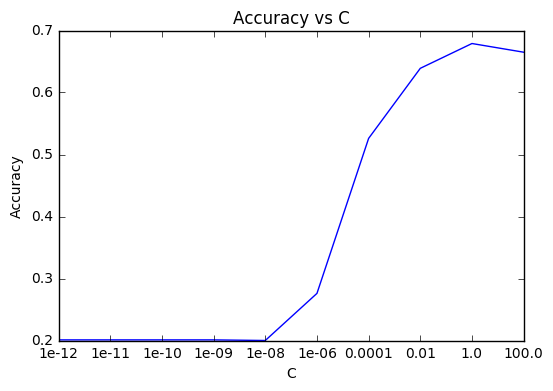

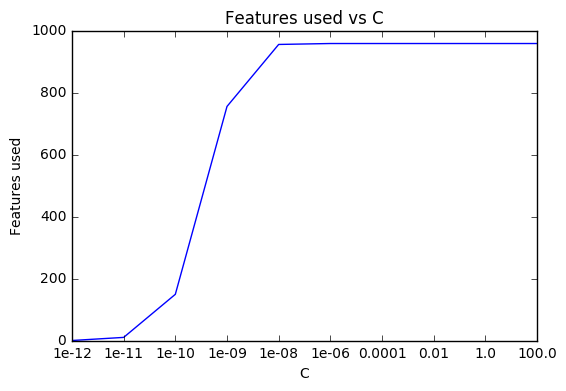

In [20]:
def get_non_zero_indices(df, tol=0.00000001):
    filter0 = abs(df[0]) >= tol
    filter1 = abs(df[1]) >= tol
    filter2 = abs(df[2]) >= tol
    filter3 = abs(df[3]) >= tol
    indices = df[filter0 | filter1 | filter2 | filter3].index.values
    return indices

def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    # Fit and transform a CountVectorizer on the training data set and transform the dev data set
    vec = CountVectorizer()
    t_data = vec.fit_transform(train_data)
    d_data = vec.transform(dev_data)
    print "Base vocabulary (number of features):", t_data.shape[1], "\n"

    # Define and fit a Logistic Regression with L1 regularization
    clf = LogisticRegression(penalty='l1')
    clf.fit(t_data, train_labels)
    dev_preds = clf.predict(d_data)
    l1_f1 = round(metrics.f1_score(dev_labels,dev_preds,average='weighted'),3) 
    coefs = pd.DataFrame(clf.coef_).transpose()
    l1_indices = get_non_zero_indices(coefs)
    print "Non-zero weights with L1 regularization:", coefs.astype(bool).sum(axis=0).sum(), "out of", t_data.shape[1]*coefs.shape[1]
    print "F1 score:", l1_f1, "\n"

    l1_vocab = [list(vec.get_feature_names())[index] for index in l1_indices]

    # Logistic Regression with L2 regularization
    clf = LogisticRegression(penalty='l2')
    clf.fit(t_data, train_labels)
    dev_preds = clf.predict(d_data)
    l2_f1 = round(metrics.f1_score(dev_labels,dev_preds,average='weighted'),3) 
    coefs = pd.DataFrame(clf.coef_).transpose()
    print "Non-zero weights with L2 regularization:", coefs.astype(bool).sum(axis=0).sum(), "out of", t_data.shape[1]*coefs.shape[1]
    print "F1 score:", l2_f1, "\n"

    # Fit and transform a CountVectorizer on the training data set and transform the dev data set
    # with vocabulary from the L1 based model
    vec = CountVectorizer(vocabulary=l1_vocab)
    t_data = vec.fit_transform(train_data)
    d_data = vec.transform(dev_data)
    print "L1 based vocabulary (number of features):", t_data.shape[1], "\n"

    # Re-train the Logistic Regression using L2 regularization and the L1 vocabulary
    C = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-6, 1e-4, 1e-2, 1e-0, 1e2]
    accuracy = []
    features_used = []
    for i in C:
        clf = LogisticRegression(C=i, penalty='l2', tol=0.01)
        clf.fit(t_data, train_labels)
        dev_preds = clf.predict(d_data)
        f1 = round(metrics.f1_score(dev_labels,dev_preds,average='weighted'),3) 
        coefs = pd.DataFrame(clf.coef_).transpose()
        features_used_indices = get_non_zero_indices(coefs)
        print "C value:", i
        print "Number of used features:", len(features_used_indices)
        print "Non-zero weights with L2 regularization:", coefs.astype(bool).sum(axis=0).sum(), "out of", t_data.shape[1]*coefs.shape[1]
        print "F1 score:", f1
        print ""

        accuracy.append(f1)
        features_used.append(len(features_used_indices))

    N = len(C)
    x2 = np.arange(N)
    plt.plot(x2,accuracy)
    plt.xticks(x2,C)
    plt.title("Accuracy vs C")
    plt.ylabel("Accuracy")
    plt.xlabel("C")
    plt.show()

    plt.plot(x2,features_used)
    plt.xticks(x2,C)
    plt.title("Features used vs C")
    plt.ylabel("Features used")
    plt.xlabel("C")
    plt.show()

P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

ANSWER: The CountVectorizer simply counts the frequency of each feature in each example in the corpus across all features from the corpus, so common features such as the word 'the' will likely have high freqencies across many of the examples in the corpus. As such the word 'the' is potentially not a great differentiator or predictor of each example. The TfidfVectorizer attempts to take account of this possible shortcoming of the CountVectorizer by first running the CountVectorizer and then normalizing the example frequencies by the inverse of the corpus frequency to effectively de-weight the importance of features that are common across the corpus. 

In [21]:
def find_high_R(clf, data, labels, num=3):
    # Calculate probabilities for each label for each example 
    d_probs = clf.predict_proba(data)
    # Create a dataframe and input max label probability, correct label probability and the ratio
    probs = pd.DataFrame(d_probs, columns=['0','1','2','3'])
    probs['max'] = probs[['0','1','2','3']].max(axis=1)
    probs['correct_label'] = labels
    prob_correct = []
    for i in range(len(d_probs)):
        prob_correct.append(d_probs[i][labels[i]])
    prob_correct = pd.DataFrame(prob_correct, columns=['prob_correct'])
    probs['prob_correct'] = prob_correct
    probs['R'] = probs['max'] / probs['prob_correct']
    # Sort dev data predictions by R descending to get top 3 mistakes
    print probs.sort_values(by='R', ascending=False).head(num)
    ind_values = probs.sort_values(by='R', ascending=False).head(num).index.values
    return ind_values

def P7():
    # Fit and transform the train_data using the TfidfVectorizer
    vec = TfidfVectorizer()
    t_data = vec.fit_transform(train_data)
    # transform the dev_data using the fitted train_data vec
    d_data = vec.transform(dev_data)
    # Define and fit Logistic Regression classifier using the t_data
    clf = LogisticRegression(C=100, solver='newton-cg')
    clf.fit(t_data,train_labels)
    # Make predictions using the fitted model on the dev_data
    preds = clf.predict(d_data)
    print "Dev data F1 score:", round(metrics.f1_score(dev_labels,preds,average='weighted'),3) 
    print ""
    print "Dev data classification report:"
    print classification_report(dev_labels,preds)
    print ""
    print "Top 3 documents where R is the largest:"
    ind_values = find_high_R(clf, d_data, dev_labels)
    print ""
    for i in ind_values:
        print "="*100
        print "Example:", i
        print "-"*100
        print "Text:"
        print dev_data[i]
        print "-"*100
        print "Predicted: ", preds[i], newsgroups_train.target_names[preds[i]]
        print "True Label: ", dev_labels[i], newsgroups_train.target_names[dev_labels[i]]
        print "="*100
 
P7()

Dev data F1 score: 0.76

Dev data classification report:
             precision    recall  f1-score   support

          0       0.69      0.62      0.65       165
          1       0.80      0.91      0.85       185
          2       0.83      0.83      0.83       199
          3       0.68      0.64      0.66       127

avg / total       0.76      0.76      0.76       676


Top 3 documents where R is the largest:
            0         1         2         3       max  correct_label  \
215  0.001967  0.993714  0.003248  0.001070  0.993714              3   
665  0.002910  0.979735  0.014331  0.003024  0.979735              3   
607  0.002423  0.020048  0.281894  0.695635  0.695635              0   

     prob_correct           R  
215      0.001070  928.809741  
665      0.003024  324.029014  
607      0.002423  287.124558  

Example: 215
----------------------------------------------------------------------------------------------------
Text:
I am pleased to announce that a *revised ve

ANSWER: The main mistake that the model is making in the first two examples is that it is picking up on important words from other classes that are used in common language. For example words relating to computers can also be used in advertising to highlight how you can purchase the advertised product. This might result in more words important to other classes appearing in another class and dominating classifier. The model is using the multi_class= setting of 'ovr', so one class versus the rest, but maybe there is a way to alter the weights to give more weight within a class to its more highly weighted words. Alternatively you can look to exclude words that may lead to confusion using the stop_words attribute. The Tfidf Vectorizer can also have difficulty if there is a small number of words in the example leading to volatile results, which may be the problem in the third example.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

ANSWER: The main idea I try to implement is the notion of removing common language across classes. Firstly I fit a default model using the same parameters as Question 7 as a basis of reference.

In [22]:
# Establish a default result
# Fit and transform the train_data using a TfidVectorizerVectorizer from Q7
vec = TfidfVectorizer()
t_data = vec.fit_transform(train_data)
d_data = vec.transform(dev_data)
# Fit a Logistic Regression with C=100, solver='newton-cg'
clf = LogisticRegression(C=100, solver='newton-cg')
# Fit the classifier using the fitted and transformed train_data
clf.fit(t_data,train_labels)
# make predictions on the dev_data
d_preds = clf.predict(d_data)
default_result = round(metrics.f1_score(dev_labels,d_preds,average='weighted'),3) 
print "Default result for comparison:"
print "Default F1 score:", default_result

Default result for comparison:
Default F1 score: 0.76


Next I focus on model parameters that reduce the feature set with emphasis on words that may be specific to a class, but also common language in others, which may cause confusion with predictions. To do so I have a look for features that have a high weight for one class and a low weight for another class to create a list of possible words to exclude.

In [23]:
# Establish a default result
# Fit and transform the train_data using a CountVectorizer
hurdle = 2
vec = TfidfVectorizer()
t_data = vec.fit_transform(train_data)
d_data = vec.transform(dev_data)
vocab = list(vec.get_feature_names())
# Fit a Logistic Regression with C=100, solver='newton-cg'
clf = LogisticRegression(C=100, solver='newton-cg')
# Fit the classifier using the fitted and transformed train_data
clf.fit(t_data,train_labels)
# make predictions on the dev_data
d_preds = clf.predict(d_data)
#final = get_largest_weights(vec, clf, 20)
large_weights = get_largest_weights(vec, clf, 20, False)
df = large_weights
filter0 = abs(df['0']) < hurdle
filter1 = abs(df['1']) < hurdle
filter2 = abs(df['1']) < hurdle
filter3 = abs(df['1']) < hurdle
extra_stop_words1 = list(df[filter0 | filter1 | filter2 | filter3].Feature.values)
print "Extra stop words 1:"
print extra_stop_words1



Extra stop words 1:
[u'atheists', u'bobby', u'islam', u'atheist', u'motto', u'nanci', u'enviroleague', u'matthew', u'loans', u'satan', u'posting', u'post', u'natural', u'must', u'computer', u'42', u'sgi', u'3do', u'using', u'animation', u'card', u'video', u'sphere', u'mars', u'nick', u'allen', u'earth', u'get', u'down', u'funding', u'blood', u'order', u'christ', u'hudson', u'koresh', u'children', u'abortion', u'terrorist', u'rosicrucian', u'ekr', u'amorc', u'dead', u'convenient']


As another way I identify all the erroneous predictions and fit a model on those examples to identify as above the highly weighted words that have low weights on other classes.

In [24]:
# Establish a default result
# Fit and transform the train_data using a CountVectorizer
vec = TfidfVectorizer()
t_data = vec.fit_transform(train_data)
d_data = vec.transform(dev_data)
vocab = list(vec.get_feature_names())
# Fit a Logistic Regression with C=100, solver='newton-cg'
clf = LogisticRegression(C=100, solver='newton-cg')
# Fit the classifier using the fitted and transformed train_data
clf.fit(t_data,train_labels)
# make predictions on the dev_data
d_preds = clf.predict(d_data)

# Calculate probabilities for each label for each example 
d_probs = clf.predict_proba(d_data)
# Create a dataframe and input max label probability, correct label probability and the ratio
probs = pd.DataFrame(d_probs, columns=['0','1','2','3'])
probs['max'] = probs[['0','1','2','3']].max(axis=1)
probs['correct_label'] = dev_labels
prob_correct = []
for i in range(len(d_probs)):
    prob_correct.append(d_probs[i][dev_labels[i]])
prob_correct = pd.DataFrame(prob_correct, columns=['prob_correct'])
probs['prob_correct'] = prob_correct
probs['R'] = probs['max'] / probs['prob_correct']
probs
ind_list = [0]*4
for i in range(4):
    filter = (probs['R'] > 2) & (probs['correct_label']==i)
    ind_list[i] = list(probs[filter].index.values)

bad_examples = [train_data[int(item)] for i in range(4) for item in ind_list[i]] 
bad_labels = [train_labels[int(item)] for i in range(4) for item in ind_list[i]] 
bad_vec = TfidfVectorizer()
bad_t_data = bad_vec.fit_transform(bad_examples)
vocab = list(bad_vec.get_feature_names())
bad_t_data.shape
bad_clf = LogisticRegression(C=100, solver='newton-cg')
# Fit the classifier using the fitted and transformed train_data
bad_clf.fit(bad_t_data,bad_labels)
table = get_largest_weights(bad_vec, bad_clf, 20, False)
hurdle = 1
df = table
filter0 = abs(df['0']) < hurdle
filter1 = abs(df['1']) < hurdle
filter2 = abs(df['1']) < hurdle
filter3 = abs(df['1']) < hurdle
extra_stop_words2 = list(df[filter0 | filter1 | filter2 | filter3].Feature.values)

print "Extra stop words 2:"
print extra_stop_words2



Extra stop words 2:
[u'quran', u'war', u'society', u'argument', u'too', u'muslim', u'image', u'graphics', u'daemon', u'scodal', u'graeme', u'pens', u'buggy', u'generated', u'sphinx', u'software', u'fractal', u'fonts', u'povray', u'minutes', u'colours', u'moon', u'antenna', u'nasa', u'chuck', u'flights', u'yeager', u'technology', u'station', u'piper', u'_______________________________________________________________________________', u'curiousity', u'worden', u'check', u'idea', u'flight', u'id', u'rockets', u'lord', u'christ', u'jesus', u'someone', u'definition', u'asked', u'when', u'brian', u'amorc', u'your', u'details', u'lds', u'brought', u'appreciate', u'context']


In [25]:
# set up my own extra stop words basd on direct observation as an example
extra_stop_words3 = ['email','online','web','website','internet','address', 'com', 'site']


In the version below I exclude the above groups of words from the vocabulary plus the inbuilt set of common words in the stop words vocabulary.

In [26]:
def P8():
    
    extra = [extra_stop_words1, extra_stop_words2, [], extra_stop_words3]
    extra1 =['Extra Words 1', 'Extra Words 2', 'Stop Words Only', 'Extra Words 3']
    extras = zip(extra,extra1)
    for i,j in extras:
        my_stop_words = ENGLISH_STOP_WORDS.union(i)
        # Fit and transform the train_data using the TfidfVectorizer with different stop_words
#        vec = TfidfVectorizer(preprocessor=better_preprocessor,stop_words=my_stop_words)
        vec = TfidfVectorizer(stop_words=my_stop_words)
        t_data = vec.fit_transform(train_data)
        d_data = vec.transform(dev_data)
        print "Stop word adjusted number of features:", t_data.shape[1]
        # Set up and fit the Logistic Regression
        clf = LogisticRegression(C=100, solver='newton-cg') 
        clf.fit(t_data,train_labels)
        d_preds1 = clf.predict(d_data)
        d_preds1.shape
        print "Tfidf", j, "F1 score:", round(metrics.f1_score(dev_labels,d_preds1,average='weighted'),3)   
        print ""
        
P8()

Stop word adjusted number of features: 26536
Tfidf Extra Words 1 F1 score: 0.757

Stop word adjusted number of features: 26527
Tfidf Extra Words 2 F1 score: 0.769

Stop word adjusted number of features: 26576
Tfidf Stop Words Only F1 score: 0.777

Stop word adjusted number of features: 26570
Tfidf Extra Words 3 F1 score: 0.778



ANSWER: My methods of identifying words that may be causing prediction difficulties were not overly successful. However, by simply removing stop words the F1 score goes up from the default level of 0.76 to 0.777, which supports the merit of the idea. By further adding the observed words possibly causing the problem identified in part Q7, i.e. 'extra words 3', I was able to squeeze out .1% more F1 score to 0.778 from just 6 further words, which again supports the merit of the idea.